# Part 4: Becoming a Backprop Ninja

Viele ML Frameworks bieten direkt "AutoGrad" an. Z.B. PyTorch, TensorFlow, MXNet, etc.

Wir wollen nun aber selbst eine Implementierung vornehmen, um ein echter Backpropagation Ninja zu werden.

Als Beispiel verwenden wir wieder ein MLP das Trigramme der Vornamen bekommt und den 4. Buchstaben vorhersagen soll.

In [48]:
import torch
import torch.nn.functional as F # torch.nn.functional is a module that contains all the functions in the torch.nn library
import matplotlib.pyplot as plt
import random

### Datenvorbereitung

In [2]:
words = open("names.txt", "r").read().splitlines()
print(len(words))
print(words[:10])

32033
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
chars = sorted(set(''.join(words)))
print(chars)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [4]:
char2idx = {c: i+1 for i, c in enumerate(chars)}
char2idx['.'] = 0
print(char2idx)

idx2char = {i: c for c, i in char2idx.items()}
print(idx2char)

vocab_size = len(idx2char)
print(vocab_size)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [49]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = char2idx[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
shuffled_words = words.copy()
random.shuffle(shuffled_words)
n1 = int(0.8 * len(shuffled_words))
n2 = int(0.9 * len(shuffled_words))

Xtr, Ytr = build_dataset(words[:n1]) # 80% training
print("Train Length: ", len(Xtr))
Xdev, Ydev = build_dataset(words[n1:n2]) # 10% development
print("Dev   Length: ", len(Xdev))
Xte, Yte = build_dataset(words[n2:]) # 10% test
print("Test  Length: ", len(Xte))

Train Length:  182778
Dev   Length:  22633
Test  Length:  22735


In [30]:
print(Xtr[0]),
print("---->")
print(Ytr[0])

tensor([0, 0, 0])
---->
tensor(5)


In [29]:
print(idx2char[Xtr[0][0].item()], idx2char[Xtr[0][1].item()], idx2char[Xtr[0][2].item()])
print("---->")
print(idx2char[Ytr[0].item()])

. . .
---->
e


### Aufbau des NNs

In [66]:
# Utility Function um Gradienten manuell zu berchnen und mit den AutoGrad's von PyTroch zu vergleichen
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item() # 1. Variante checkt ob die beiden Tensoren gleich sind
    app = torch.allclose(dt, t.grad)    # 2. Variante checkt ob die beiden Tensoren fast gleich sind
    maxdiff = (dt - t.grad).abs().max().item() # gibt den maximalen Unterschied zwischen den beiden Tensoren zurück
    print(f"{s:15s} | exact: {str(ex):5s} | approx: {str(app):5s} | maxdiff: {maxdiff}")

In [67]:
n_embd = 10
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)

# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size) ** 0.5) # fan_in = n_embd * block_size, damit Gewichte normalverteilt sind, wegen Sättigung der tanh
b1 = torch.randn((n_hidden,), generator=g) * 0.1 # eig wayne, weil durch BatchNorm Bias ersetzt
# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn((vocab_size,), generator=g) * 0.1
# BatchNorm
bngain = torch.randn((1, n_hidden), generator=g) * 0.1 + 1.0 # auch als "gamma" bezeichnet, skaliert die Normalverteilung der Aktivierung, damit sie nicht zu klein wird
bnbias = torch.randn((1, n_hidden), generator=g) * 0.1 # auch als "beta" bezeichnet, verschiebt die Normalverteilung der Aktivierung

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [68]:
# Erstellen eines Mini-Batches
batch_size = 32
n = batch_size
# Parameter stehen für: low, high, size, generator -> random index im Bereich von 0 bis Xtr.shape[0], davon 32 Stück
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [70]:
# Forward Pass
 
emb = C[Xb] # (32, 3, 10)
embcat = emb.view(emb.shape[0], -1) # (32, 30)

# Linear Layer 1
zprebn = embcat @ W1 + b1 # (32, 64) -> Hidden Layer Pre-Activation z

# BatchNorm Layer (Eingaben vom Ersten Hidden Layer werden normalisiert, damit die Aktivierungsfunktion nicht zu klein oder zu groß wird / Gradienten nicht zu klein werden, wegen der Sättigung der tanh)
bnmeani = 1/n * zprebn.sum(dim=0, keepdim=True) # (1, 64) # von allen 32 Samples den Mittelwert berechnen
bndiff = zprebn - bnmeani # (32, 64) # von allen 32 Samples den Mittelwert abziehen -> Abweichung
bndiff2 = bndiff ** 2 # (32, 64) # Abweichung quadrieren -> Varianz
bnvar = 1/(n-1) * bndiff2.sum(dim=0, keepdim=True) # (1, 64) # Varianz berechnen (n-1 ist Bessels Korrektur, weil wir sonst die Varianz tendenziell unterschätzen)
bnvar_inv = (bnvar + 1e-5) ** -0.5 # (1, 64) # Inverse Wurzel der Varianz berechnen, für Normalisierung
bnraw = bndiff * bnvar_inv # (32, 64)
apreact = bngain * bnraw + bnbias # (32, 64) # Skalierung und Verschiebung der Normalisierten Werte, um die Aktivierung zu normalisieren
# Nicht-Lineare Aktivierungsfunktion
a = torch.tanh(apreact) # (32, 64) # tanh Aktivierungsfunktion

# Linear Layer 2
logits = a @ W2 + b2 # (32, 64) @ (64, 27) + (27,) -> (32, 27)

# Cross Entropy Loss (Softmax + Negative Log Likelihood)
logit_maxes = logits.max(dim=1, keepdim=True).values # (32, 1) # Maximalen Wert von jedem Sample berechnen
norm_logits = logits - logit_maxes # (32, 27) # Logits normalisieren, damit es keine Overflows gibt, weil das kommt danach ja in Softmax, also exp, und sonst würden wir inf bekommen
counts = norm_logits.exp() # (32, 27) # Exponentialfunktion auf die normalisierten Logits anwenden
counts_sum = counts.sum(dim=1, keepdim=True) # (32, 1) # Summe der Exponentialfunktionen berechnen
counts_sum_inv = counts_sum ** -1 # (32, 1) # Inverse der Summe berechnen
probs = counts * counts_sum_inv # (32, 27) # Wahrscheinlichkeiten berechnen
logprobs = probs.log() # (32, 27) # Logarithmus der Wahrscheinlichkeiten berechnen
loss = -logprobs[range(n), Yb].mean() # (32,) # Negative Log Likelihood berechnen


# Pytorch Autograd
for p in parameters:
    p.grad = None

for t in [logprobs, probs, counts_sum_inv, counts_sum, counts, norm_logits, logit_maxes, logits, a, apreact, bnraw, bnvar_inv, bndiff2, bndiff, bnmeani, zprebn, embcat, emb]:
    t.retain_grad() # PyTorch soll die Gradienten der Tensoren speichern

loss.backward()
loss

tensor(3.3734, grad_fn=<NegBackward0>)

Nun gehen wir angfangen bei `loss` alle Teile der Cost-Function durch und bilden die Ableitungen von Hand. Wir machen Backpropagation vom Scratch:

In [10]:
# loss = -logprobs[range(n), Yb].mean()
# hier sind die 32 Outputs drin aus Softmax bei den Samples und dann quasi durch 32 geteilt und alle negativ, weil wir ja die negative Log Likelihood berechnen
# loss = -(a + b + c) / 3    <-- 3 hier weil wir durch die Summe teilen für mean()
# dloss/da = -1/3a + -1/3b + -1/3c 
# dlass/da = -1/3
# dloss/db = -1/3
# dloss/dc = -1/3
# dloss/dx = -1/x*n
# Das gilt natürlich nun für alle 32 Werte, wobei es ja eig (32, 27) waren, die werden aber nicht verwendet wegen unserem Yb mapping, also alle "0", weil quasi Konstanten
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0 / n
dlogprobs

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0312,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0312,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000, -0.0312,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.0312,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000

In [11]:
# überprüfen mit Utiltiy Function cmp()
cmp("logprobs", dlogprobs, logprobs)

logprobs        | exact: True  | approx: True  | maxdiff: 0.0


Unser eigener Gradient für `logprobs`, passt genau zu dem vom PyTorch AutoGrad.

Nun machen wir weiter mit der Ableitung von `logprobs = probs.log()`, wobei die Ableitung einfach:

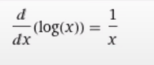

ist.

In [12]:
# logprobs = probs.log() # (32, 27) # Logarithmus der Wahrscheinlichkeiten berechnen
dprobs = (1.0 / probs) * dlogprobs # Kettenregel f(g(x)) = f'(g(x)) * g'(x)
cmp("probs", dprobs, probs)

probs           | exact: True  | approx: True  | maxdiff: 0.0


Dadurch das wir $(1.0 / probs) * dlogprobs$ haben, werden werte die Gradienten der Ausgänge mit einer gerigneren "probs" geboosted.

In [13]:
counts.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [14]:
# c = a * b
# a(3x3) * b(3x3) = c(3x3)
# a11*b1 + a12*b1 + a13*b1
# a21*b2 + a22*b2 + a23*b2
# a31*b3 + a32*b3 + a33*b3 ...
# = c(3x3)
dcounts_sum_inv = (counts * dprobs).sum(dim=1, keepdim=True) # (32, 1)
cmp("counts_sum_inv", dcounts_sum_inv, counts_sum_inv)

counts_sum_inv  | exact: True  | approx: True  | maxdiff: 0.0


Fassen wir kurz zusammen, sehen wir raum hier wieder `dprobs` verwendet wurde:

In [15]:
# loss = -logprobs[range(n), Yb].mean()
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0 / n
# logprobs = probs.log()
dprobs = (1.0 / probs) * dlogprobs
# probs = counts * counts_sum_inv
dcounts_sum_inv = (counts * dprobs).sum(dim=1, keepdim=True)

cmp("logprobs", dlogprobs, logprobs)
cmp("probs", dprobs, probs)
cmp("counts_sum_inv", dcounts_sum_inv, counts_sum_inv)

logprobs        | exact: True  | approx: True  | maxdiff: 0.0
probs           | exact: True  | approx: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approx: True  | maxdiff: 0.0


In [74]:
dlogprobs = torch.zeros_like(logprobs) # loss = -logprobs[range(n), Yb].mean()
dlogprobs[range(n), Yb] = -1.0 / n
dprobs = (1.0 / probs) * dlogprobs # logprobs = probs.log()
dcounts_sum_inv = (counts * dprobs).sum(dim=1, keepdim=True) # probs = counts * counts_sum_inv -> nach "counts_sum_inv" ableiten
dcounts = counts_sum_inv * dprobs # probs = counts * counts_sum_inv -> nach "counts" ableiten
dcounts_sum = (-counts_sum ** -2) * dcounts_sum_inv # counts_sum_inv = counts_sum ** -1 -> nach "counts_sum" ableiten
# counts_sum = counts.sum(dim=1, keepdim=True) -> nach "counts" ableiten
dcounts += torch.ones_like(counts) * dcounts_sum # hier kommt += rein, weil wir quasi in einem weiteren Ableitungszweig von "counts" sind
dnorm_logits = counts * dcounts # counts = norm_logits.exp() -> nach "norm_logits" ableiten
# norm_logits = logits - logit_maxes -> nach "logit_maxes" ableiten
dlogits = dnorm_logits.clone() # nicht das finale dlogits, sondern nur die Ableitung von "norm_logits" nach "logits", alsi wieder ein Zweig, der später noch verändert werden muss
dlogit_maxes = -dlogits.sum(dim=1, keepdim=True)
dlogits += F.one_hot(logits.max(dim=1).indices, num_classes=logits.shape[1]) * dlogit_maxes # logit_maxes = logits.max(dim=1, keepdim=True).values
dh = dlogits @ W2.T
dW2 = a.T @ dlogits
db2 = dlogits.sum(dim=0)
da = (1.0 - a**2) * dh
dbngain = (bnraw * da).sum(dim=0, keepdim=True)
dbnraw = bngain * da
dbnbias = da.sum(dim=0, keepdim=True)
dbnvar_inv = (bndiff * dbnraw).sum(dim=0, keepdim=True)
dbnvar = (-0.5 * (bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dbnvar



cmp("logprobs", dlogprobs, logprobs)
cmp("probs", dprobs, probs)
cmp("counts_sum_inv", dcounts_sum_inv, counts_sum_inv)
cmp("dcounts", dcounts, counts)
cmp("dcounts_sum", dcounts_sum, counts_sum)
cmp("dnorm_logits", dnorm_logits, norm_logits)
cmp("dlogits", dlogits, logits)
cmp("dlogit_maxes", dlogit_maxes, logit_maxes)
cmp("dh", dh, zprebn)
cmp("dW2", dW2, W2)
cmp("db2", db2, b2)
cmp("da", da, a)
cmp("dbngain", dbngain, bngain)
cmp("dbnraw", dbnraw, bnraw)
cmp("dbnbias", dbnbias, bnbias)
cmp("dbnvar_inv", dbnvar_inv, bnvar_inv)
cmp("dbnvar", dbnvar, bnvar)
cmp("dbndiff2", dbndiff2, bndiff2)

logprobs        | exact: True  | approx: True  | maxdiff: 0.0
probs           | exact: True  | approx: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approx: True  | maxdiff: 0.0
dcounts         | exact: True  | approx: True  | maxdiff: 0.0
dcounts_sum     | exact: True  | approx: True  | maxdiff: 0.0
dnorm_logits    | exact: True  | approx: True  | maxdiff: 0.0
dlogits         | exact: True  | approx: True  | maxdiff: 0.0
dlogit_maxes    | exact: True  | approx: True  | maxdiff: 0.0
dh              | exact: False | approx: False | maxdiff: 0.00974796712398529
dW2             | exact: True  | approx: True  | maxdiff: 0.0
db2             | exact: True  | approx: True  | maxdiff: 0.0
da              | exact: False | approx: False | maxdiff: 0.00838204100728035
dbngain         | exact: True  | approx: True  | maxdiff: 0.0
dbnraw          | exact: True  | approx: True  | maxdiff: 0.0
dbnbias         | exact: True  | approx: True  | maxdiff: 0.0
dbnvar_inv      | exact: True  | appro

C:\Users\High Performance\AppData\Local\Temp\ipykernel_12532\3253760475.py:3: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten\src\ATen/core/TensorBody.h:494.)
  ex = torch.all(dt == t.grad).item() # 1. Variante checkt ob die beiden Tensoren gleich sind


TypeError: all() received an invalid combination of arguments - got (bool), but expected one of:
 * (Tensor input, *, Tensor out)
 * (Tensor input, tuple of ints dim, bool keepdim, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, Tensor out)
 * (Tensor input, name dim, bool keepdim, *, Tensor out)


Er hat hier einfach backprop weitergeführt und dann in das NN eingebaut. Machen wir nicht weiter, weil pain in the ass.